<a href="https://colab.research.google.com/github/AndresInsuasty/tesis-cafes-especiales/blob/main/pix2pix_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook creado para implementar rutina de inferencia de modelo pix2pix

## Librerias

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

## Rutas

In [3]:
# Ruta de datos de entrada
PATH_NDVI = '/content/drive/MyDrive/segmentado/dataset2/ndvi/'

# Ruta imagenes de salida
PATH_OUTPUT = '/content/drive/MyDrive/segmentado/dataset2/labels/'

# Ruta modelo
PATH_MODEL = '/content/drive/MyDrive/segmentado/pix2pix/pix2pixmodelNDVI20212809.h5'

## Listando imagenes

In [4]:
imgurls = !ls -1 "{PATH_NDVI}"

Transformado de imagenes

In [11]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
# Reescalar imagenes
def resize(inimg,tgimg, height,width):
    inimg = tf.image.resize(inimg,[height,width])
    tgimg = tf.image.resize(tgimg,[height,width])

    return inimg,tgimg

# Normalizar el rango [-1, +1] la imagen
def normalize(inimg,tgimg):
    inimg = (inimg/127.5)-1
    tgimg = (tgimg/127.5)-1

    return inimg,tgimg

def random_jitter(inimg,tgimg):
    inimg,tgimg = resize(inimg,tgimg,286,286)

    stacked_image = tf.stack([inimg,tgimg],axis=0)
    croppped_image = tf.image.random_crop(stacked_image,size=[2,IMG_WIDTH,IMG_HEIGHT,3])

    inimg,tgimg = croppped_image[0], croppped_image[1]

    if tf.random.uniform(())>0.5:
        inimg = tf.image.flip_left_right(inimg)
        tgimg = tf.image.flip_left_right(tgimg)

    return inimg,tgimg

def load_image(filename, augment=False):
    inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(PATH_NDVI + filename)),tf.float32)
    tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(PATH_NDVI + filename)),tf.float32)
    
    inimg, tgimg = resize(inimg, tgimg, IMG_WIDTH, IMG_HEIGHT)
    
    if augment:
        inimg,tgimg = random_jitter(inimg,tgimg)
    
    inimg,tgimg = normalize(inimg,tgimg)
    return inimg,tgimg

def leer_imagen(path):
    dim = (256,256)
    im = cv2.imread(path)
    im_r = cv2.resize(im,dim)
    return im_r
    
def load_data(urls,path):
    im_s = np.empty((1, 256,256,3))
    im_aux = np.empty((1, 256,256,3))
    cont=0
    for url in urls:
        im = leer_imagen(path + url)
        if cont == 0:
            im_s[0,...] = im
            cont +=1
        else:
            im_aux[0,...] = im
            im_s = np.append(im_s,im_aux,axis=0)
    if cont %100 ==0:
        print(cont)
    return im_s

## Cargar Modelo

In [12]:
p2p_model = load_model(PATH_MODEL)

## Predict

In [34]:
def p2p_predict(i):
    entrada,etiqueta =load_image(imgurls[i])
    aux=np.zeros([1,256,256,3])
    salida2 = np.zeros([1,256,256,3])
    aux[0,...]=entrada # el modelo necesita una entrada de 4 dimensiones (examples,rows,columns,caps)
    salida = p2p_model(aux,training=True)
    salida2[...,0] = salida[...,2]
    salida2[...,1] = salida[...,1]
    salida2[...,2] = salida[...,0]
    return salida2

## Probando Predict

In [23]:
imagen = 0
entrada,etiqueta =load_image(imgurls[imagen])
p2p_p = p2p_predict(imagen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


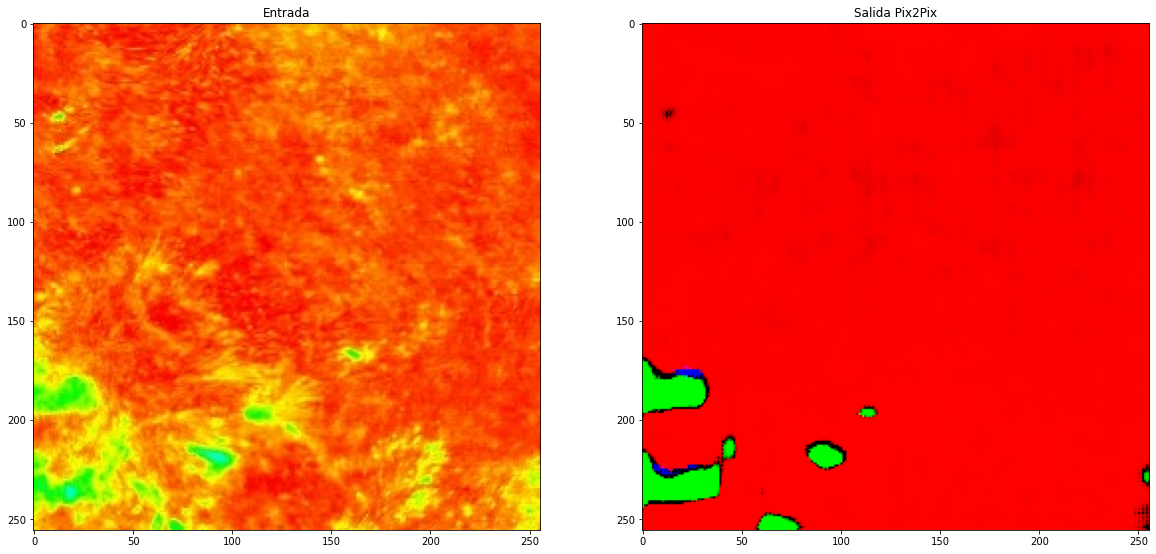

In [24]:
plt.figure(figsize=(20,12))

plt.subplot(121)
plt.title('Entrada')
plt.imshow((np.squeeze(entrada)+1)/2)

plt.subplot(122)
plt.title('Salida Pix2Pix')
plt.imshow(np.squeeze(p2p_p))

## Ejecutando predicts

In [39]:
for i_img in range(len(imgurls)):
    p2p_p = np.round_((p2p_predict(i_img)+1)*127.5,decimals=0)
    filename = imgurls[i_img].replace('ndvi','label')
    cv2.imwrite('{PATH_OUTPUT}{filename}'.format(PATH_OUTPUT=PATH_OUTPUT,
                                                 filename=filename),np.squeeze(p2p_p))
print('Terminado!')

Terminado!
